In [39]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time

In [9]:
def yearday(date):
    return (date-dt.datetime(date.year,1,1)).days+1

In [32]:
PAP_lon = -16.5
PAP_lat = 49

nc = Dataset('https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/2010/001/A2010001.L3m_DAY_CHL_chl_ocx_9km.nc')
nclat = nc.variables['lat'][:]
nclon = nc.variables['lon'][:]
latinds = np.where((nclat>PAP_lat-2) & (nclat<PAP_lat+2))[0]
loninds = np.where((nclon>PAP_lon-2) & (nclon<PAP_lon+2))[0]
loc_string = '?chl_ocx[%d:1:%d][%d:1:%d]'%(latinds[0],latinds[-1]+1,loninds[0],loninds[-1]+1)
print('Example of variables to load:',loc_string)

Example of variables to load: ?chl_ocx[468:1:516][1938:1:1986]


In [101]:
years = np.arange(2003,2021,1)
yeardays = np.arange(97,178,8) # use 8-day averages
url = 'https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/%04d/%03d/A%04d%03d%04d%03d.L3m_8D_CHL_chl_ocx_9km.nc%s'


In [102]:
start_day = first_day
end_day = first_day+dt.timedelta(days=7)
print('Example URL:',url%(start_day.year,yearday(start_day),start_day.year,yearday(start_day),end_day.year,yearday(end_day),loc_string))

Example URL: https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/2013/057/A20130572013064.L3m_8D_CHL_chl_ocx_9km.nc?chl_ocx[468:1:516][1938:1:1986]


In [103]:
mean_Chl = np.empty(shape=(len(years),len(yeardays)))
percentiles_Chl = np.empty(shape=(len(years),len(yeardays),3))
for i in range(len(years)):
    print(years[i],end=' ')
    for j in range(len(yeardays)):
        try:
            nc = Dataset(url%(years[i],yeardays[j],years[i],yeardays[j],years[i],yeardays[j]+7,loc_string),'r')
        except: # system might just have timed out, wait a bit and try again
            time.sleep(3)
            nc = Dataset(url%(years[i],yeardays[j],years[i],yeardays[j],years[i],yeardays[j]+7,loc_string),'r')
        chl = np.ma.getdata(nc.variables['chl_ocx'][:]) # numpy doesn't always work well with masked values
        chl[chl<0] = np.nan
    
        mean_Chl[i,j] = np.nanmean(chl)
        percentiles_Chl[i,j] = np.nanpercentile(chl.ravel(),[25,50,75])

2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

In [175]:
xticks = np.array([yearday(dt.datetime(2013,mon,1)) for mon in [4,5,6,7]])
xticklabels = ['April','May','June','July']

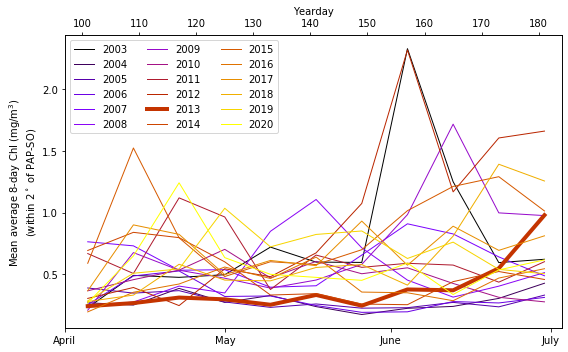

In [180]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
colors = plt.cm.get_cmap('gnuplot')(np.linspace(0,1,len(years)))
for i in range(len(years)):
    lw = 4 if years[i]==2013 else 1
    ax.plot(yeardays+4,mean_Chl[i],c=colors[i],lw=lw,label=years[i])
ax.legend(loc=0,ncol=3)
ax.set_xlim([yeardays[0],yeardays[-1]+7])
axx = ax.twiny()
ax.xaxis.tick_top()
axx.xaxis.tick_bottom()
axx.set_xlim(ax.get_xlim())
axx.set_xticks(xticks)
axx.set_xticklabels(xticklabels)
ax.set_ylabel('Mean average 8-day Chl (mg/m$^3$)\n(within 2$^\circ$ of PAP-SO)')
ax.set_xlabel('Yearday')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.savefig('PAPSO_Chl.png',dpi=300)

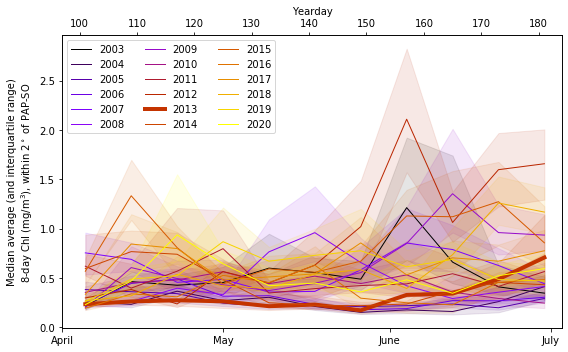

In [192]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
#ax = ax[0]
colors = plt.cm.get_cmap('gnuplot')(np.linspace(0,1,len(years)))
for i in range(len(years)):
    lw = 4 if years[i]==2013 else 1
    ax.plot(yeardays+4,percentiles_Chl[i,:,1],c=colors[i],lw=lw,label=years[i])
    ax.fill_between(yeardays+4,*percentiles_Chl[i,:,[0,2]],color=colors[i],alpha=0.1)
ax.legend(loc=0,ncol=3)
ax.set_xlim([yeardays[0],yeardays[-1]+7])
axx = ax.twiny()
ax.xaxis.tick_top()
axx.xaxis.tick_bottom()
axx.set_xlim(ax.get_xlim())
axx.set_xticks(xticks)
axx.set_xticklabels(xticklabels)
ax.set_ylabel('Median average (and interquartile range)\n8-day Chl (mg/m$^3$), within 2$^\circ$ of PAP-SO')
ax.set_xlabel('Yearday')
ax.xaxis.set_label_position('top')
plt.tight_layout()